# Combining multiple blocking passes

In the [detailed deduplication tutorial](./deduplication_detailed_example.ipynb) we discussed a problem with blocking rules: it's rare to find a rule with both very high recall and high sensitivty.

We recommend instead running multiple splink jobs with different blocking rules, with the aim of finding global parameters.

This notebook contains an example of how to do this.

## Step 1:  Imports and setup

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark() 

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Job 1: Block on forename 

In [5]:
settings_first_name = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.first_name = r.first_name"
    ],
    "comparison_columns": [
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city",
            "term_frequency_adjustments": True
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In [6]:
from splink.estimate import estimate_u_values
settings_first_name_with_u = estimate_u_values(settings_first_name, df, spark, fix_u_probabilities=True)

In [7]:
from splink import Splink
linker_fn = Splink(settings_first_name_with_u, df, spark)
df_e_fn = linker_fn.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.22885468006134035 for key dob, level 1
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.06432151794433594 for key dob, level 0
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.01809200644493103 for key email, level 0
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.0058144330978393555 for key email, level 0
INFO:splink.iterate:EM algorithm has converged


## Job 2: Block on surname

In [8]:
settings_surname = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.surname = r.surname"
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city",
            "term_frequency_adjustments": True
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In [9]:
from splink.estimate import estimate_u_values
settings_surname_with_u = estimate_u_values(settings_surname, df, spark, fix_u_probabilities=True)

In [10]:
from splink import Splink
linker_sn = Splink(settings_surname_with_u, df, spark)
df_e_sn = linker_sn.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.18537762165069582 for key dob, level 1
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.05372816324234009 for key dob, level 0
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.017128735780715942 for key dob, level 0
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.005950570106506348 for key dob, level 1
INFO:splink.iterate:EM algorithm has converged


## Job 3: Block on dob

In [11]:
settings_dob = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.dob = r.dob"
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "city",
            "term_frequency_adjustments": True
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In [12]:
from splink.estimate import estimate_u_values
settings_dob_with_u = estimate_u_values(settings_dob, df, spark, fix_u_probabilities=True)

In [13]:
from splink import Splink
linker_db = Splink(settings_dob_with_u, df, spark)
df_e_db = linker_db.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.42148728370666505 for key proportion_of_matches
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.13432937860488892 for key proportion_of_matches
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.04863584041595459 for key proportion_of_matches
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.021563410758972168 for key proportion_of_matches
INFO:splink.iterate:Iteration 4 complete
INFO:splink.model:The maximum change in parameters was 0.010971009731292725 for key proportion_of_matches
INFO:splink.iterate:Iteration 5 complete
INFO:splink.model:The maximum change in parameters was 0.0061599016189575195 for key proportion_of_matches
INFO:splink.iterate:EM algorithm has converged


# Combine parameter estimates 


In [14]:
from splink.combine_models import ModelCombiner, combine_cc_estimates

fn_cc_1 = linker_sn.model.current_settings_obj.get_comparison_column("first_name")
fn_cc_2 = linker_db.model.current_settings_obj.get_comparison_column("first_name")
fn_cc = combine_cc_estimates([fn_cc_1, fn_cc_2])

m1 = {
    "name": "first_name",
    "model": linker_fn.model,
    "comparison_columns_for_global_lambda": [fn_cc]
}

sn_cc_1 = linker_fn.model.current_settings_obj.get_comparison_column("surname")
sn_cc_2 = linker_db.model.current_settings_obj.get_comparison_column("surname")
sn_cc = combine_cc_estimates([sn_cc_1, sn_cc_2])

m2 = {
    "name": "surname",
    "model": linker_sn.model,
    "comparison_columns_for_global_lambda": [sn_cc]
}

db_cc_1 = linker_fn.model.current_settings_obj.get_comparison_column("dob")
db_cc_2 = linker_sn.model.current_settings_obj.get_comparison_column("dob")
db_cc = combine_cc_estimates([db_cc_1, db_cc_2])

m3 = {
    "name": "dob",
    "model": linker_db.model,
    "comparison_columns_for_global_lambda": [db_cc]
}

mc = ModelCombiner([m1, m2, m3])

settings_combined = mc.get_combined_settings_dict()

In [15]:
settings_combined["blocking_rules"].append('l.email=r.email')
settings_combined["blocking_rules"].append('l.city=r.city')

In [16]:
from splink import Splink
linker_db = Splink(settings_combined, df, spark)
df_e = linker_db.manually_apply_fellegi_sunter_weights()

In [17]:
cols = ['unique_id', 'group']
dfpd_l = df.toPandas().sample(1000)[cols]
dfpd_l["join_col"] = 1
dfpd_r = dfpd_l.copy()
labels = dfpd_l.merge(dfpd_r, on = "join_col", suffixes=('_l', '_r'))
labels = labels[labels["unique_id_r"]> labels["unique_id_l"]]
labels["clerical_match_score"] = (labels["group_l"] == labels["group_r"]).astype(float)
labels = labels.drop(["group_l", "group_r", "join_col"], axis=1)
labels.head()

,unique_id_l,unique_id_r,clerical_match_score
8,747,982,0.0
10,747,957,0.0
23,747,794,0.0
33,747,801,0.0
37,747,758,0.0


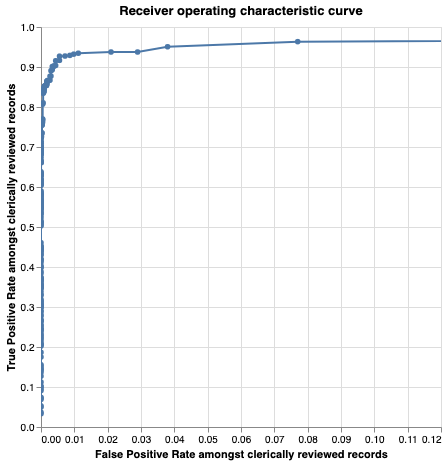

In [18]:
import altair as alt
alt.renderers.enable('mimetype')

from splink.truth import labels_with_splink_scores, roc_chart, precision_recall_chart
labels_sp = spark.createDataFrame(labels)
labels_and_scores = labels_with_splink_scores(labels_sp, df_e, "unique_id", spark, retain_all_cols=True)
roc_chart(labels_and_scores, spark)

In [19]:
from splink.truth import df_e_with_truth_categories

In [20]:
truth = df_e_with_truth_categories(labels_and_scores, 0.5, spark)
truth_pd = truth.toPandas()

In [21]:
f1 = truth_pd["FN"] == True
truth_pd[f1].sample(10)

,df_e__unique_id_l,df_e__unique_id_r,df_e__surname_l,df_e__surname_r,df_e__gamma_surname,df_e__dob_l,df_e__dob_r,df_e__gamma_dob,df_e__city_l,df_e__city_r,df_e__gamma_city,df_e__email_l,df_e__email_r,df_e__gamma_email,df_e__first_name_l,df_e__first_name_r,df_e__gamma_first_name,df_e__group_l,df_e__group_r,df_e__match_key,df_labels__unique_id_l,df_labels__unique_id_r,clerical_match_score,match_probability,found_by_blocking,truth_threshold,P,N,TP,TN,FP,FN
82835,NaN,NaN,None,None,NaN,None,None,NaN,None,None,NaN,None,None,NaN,None,None,NaN,NaN,NaN,None,279,282,1.0,0.000000,False,0.5,True,False,False,False,False,True
373430,903.0,904.0,Mirle,Miller,0.0,2018-11-18,2018-12-08,0.0,London,Londo,0.0,zmartinez@ulazqvez.com,zmartinez@velazquez.com,0.0,Chloe,Chloe,2.0,161.0,161.0,0,903,904,1.0,0.013935,True,0.5,True,False,False,False,False,True
47687,603.0,608.0,Ky,Kay,0.0,1996-05-13,1996-04-18,0.0,oeteborPugh,Peterborough,0.0,seancollins@dean.com,seancollins@dean.com,1.0,None,Ivy,-1.0,101.0,101.0,3,603,608,1.0,0.063094,True,0.5,True,False,False,False,False,True
114941,694.0,701.0,Grant,Finley,0.0,2003-07-12,2003-09-02,0.0,Salford,Salford,1.0,brownsierra@price.com,brownsierra@price.com,1.0,nleyF,Grant,0.0,118.0,118.0,3,694,701,1.0,0.240478,True,0.5,True,False,False,False,False,True
66252,130.0,132.0,Lewis,Edward,0.0,2005-05-26,2005-05-26,1.0,oLndo,London,0.0,None,whitakernichole@booth.com,-1.0,ddwaE,Lewis,0.0,24.0,24.0,2,130,132,1.0,0.039673,True,0.5,True,False,False,False,False,True
34208,421.0,424.0,Brown,Brown,2.0,2005-05-02,2005-07-15,0.0,London,London,1.0,sarahbrown@mckinney.com,sarahbroon@mckinneycwm,0.0,Eimy,None,-1.0,71.0,71.0,1,421,424,1.0,0.466550,True,0.5,True,False,False,False,False,True
121941,867.0,869.0,Smith,Smith,2.0,2004-10-25,2004-12-24,0.0,Leeds,Leeds,1.0,kath0y2r@goodman.com,kathryn20@goodman.com,0.0,eabAlla,Arabella,0.0,152.0,152.0,1,867,869,1.0,0.172531,True,0.5,True,False,False,False,False,True
146154,285.0,288.0,Sara,Joksan,0.0,1999-12-18,1999-09-18,0.0,Liverpool,Liverpool,1.0,kimashley@nguyen.info,kimaslen@yguyen.info,0.0,Jackson,Sara,0.0,48.0,48.0,4,285,288,1.0,0.000636,True,0.5,True,False,False,False,False,True
374050,930.0,932.0,None,Mills,-1.0,1970-03-09,1970-03-09,1.0,None,London,-1.0,hensondebbie@garcia.com,None,-1.0,ahoTs,Thomas,0.0,167.0,167.0,2,930,932,1.0,0.308924,True,0.5,True,False,False,False,False,True
78775,24.0,26.0,Ollie,Thompson,0.0,1996-03-22,1996-03-22,1.0,None,Leeds,-1.0,jefferyduke@brown-salazar.org,jefferyduke@brown-alazar.org,0.0,Thompson,Ollie,0.0,5.0,5.0,2,24,26,1.0,0.036166,True,0.5,True,False,False,False,False,True


In [22]:
# There are no false positives at a threshold of 0.05!
truth = df_e_with_truth_categories(labels_and_scores, 0.01, spark)
truth_pd = truth.toPandas()
f1 = truth_pd["FP"] == True
truth_pd[f1]

,df_e__unique_id_l,df_e__unique_id_r,df_e__surname_l,df_e__surname_r,df_e__gamma_surname,df_e__dob_l,df_e__dob_r,df_e__gamma_dob,df_e__city_l,df_e__city_r,df_e__gamma_city,df_e__email_l,df_e__email_r,df_e__gamma_email,df_e__first_name_l,df_e__first_name_r,df_e__gamma_first_name,df_e__group_l,df_e__group_r,df_e__match_key,df_labels__unique_id_l,df_labels__unique_id_r,clerical_match_score,match_probability,found_by_blocking,truth_threshold,P,N,TP,TN,FP,FN
40,0.0,423.0,None,Brown,-1.0,2015-10-29,2005-07-15,0.0,London,London,1.0,hannah88@powers.com,sarahbron@mckinney.com,0.0,Julia,None,-1.0,0.0,71.0,4,0,423,0.0,0.010430,True,0.01,False,True,False,False,True,False
41,0.0,425.0,None,Brown,-1.0,2015-10-29,2005-10-06,0.0,London,London,1.0,hannah88@powers.com,sarahbrown@mckinney.com,0.0,Julia,None,-1.0,0.0,71.0,4,0,425,0.0,0.010430,True,0.01,False,True,False,False,True,False
55,0.0,514.0,None,Taylor,-1.0,2015-10-29,2005-06-20,0.0,London,London,1.0,hannah88@powers.com,michellejackson@smith-trujillo.com,0.0,Julia,None,-1.0,0.0,88.0,4,0,514,0.0,0.010430,True,0.01,False,True,False,False,True,False
69,0.0,628.0,None,Long,-1.0,2015-10-29,2015-02-05,0.0,London,London,1.0,hannah88@powers.com,garciarichard@brady.com,0.0,Julia,None,-1.0,0.0,106.0,4,0,628,0.0,0.010430,True,0.01,False,True,False,False,True,False
152,1.0,343.0,Taylor,None,-1.0,2015-07-31,2016-02-18,0.0,London,London,1.0,hannah88@powers.com,duanejames@reyes.net,0.0,Julia,None,-1.0,0.0,59.0,4,1,343,0.0,0.010430,True,0.01,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499175,97.0,737.0,Morris,Walker,0.0,1983-07-20,2019-05-01,0.0,Birmingham,Leicester,0.0,emilysmith@irwin-medina.biz,jonohan52@eaton.arg,0.0,Noah,Noah,2.0,20.0,127.0,0,97,737,0.0,0.013935,True,0.01,False,True,False,False,True,False
499344,98.0,894.0,Msrio,None,-1.0,1983-07-20,2007-10-30,0.0,Birmingham,Birmingham,1.0,emilysmith@irwin-medina.biz,stephanieromero@smith.com,0.0,None,Mila,-1.0,20.0,159.0,4,98,894,0.0,0.010430,True,0.01,False,True,False,False,True,False
499453,99.0,632.0,Morris,Gibson,0.0,1983-07-20,1987-05-18,0.0,Birmingham,London,0.0,emilysmith@irwin-medina.biz,avazquez@banks.com,0.0,Noah,Noah,2.0,20.0,107.0,0,99,632,0.0,0.013935,True,0.01,False,True,False,False,True,False
499455,99.0,638.0,Morris,Gibson,0.0,1983-07-20,1987-08-21,0.0,Birmingham,London,0.0,emilysmith@irwin-medina.biz,avazquez@banks.com,0.0,Noah,Noah,2.0,20.0,107.0,0,99,638,0.0,0.013935,True,0.01,False,True,False,False,True,False


## Do we get a different ROC if we compare every row with every other (cartesian blocking)

Usually this is not possible, but with a small test dataset, the cartesian product is less than a million rows, so we can try:

In [23]:
settings_cartesian = {
    "link_type": "dedupe_only",
    "blocking_rules": [
    ],
    "comparison_columns": [
       {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city",
            "term_frequency_adjustments": True
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In [24]:
from splink import Splink
linker_c = Splink(settings_cartesian, df, spark)
df_e_c = linker_c.get_scored_comparisons()

/Users/robinlinacre/anaconda3/lib/python3.8/site-packages/splink/default_settings.py:199: UserWarning: You have not specified any blocking rules, meaning all comparisons between the input dataset(s) will be generated and blocking will not be used.For large input datasets, this will generally be computationally intractable because it will generate comparisons equal to the number of rows squared.
  warnings.warn(
INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.30443414449691775 for key dob, level 1
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.08487707376480103 for key city, level 1
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.028156936168670654 for key surname, level 0
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.016305357217788696 for key first_name, level 0
INFO:splink.iterate:Ite

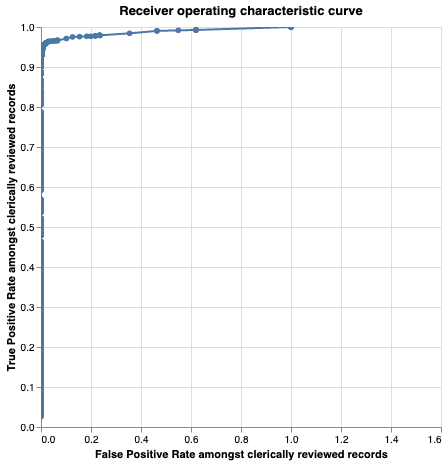

In [25]:
from splink.truth import labels_with_splink_scores, roc_chart, precision_recall_chart
labels_sp = spark.createDataFrame(labels)
labels_and_scores = labels_with_splink_scores(labels_sp, df_e_c, "unique_id", spark, retain_all_cols=True)
roc_chart(labels_and_scores, spark)